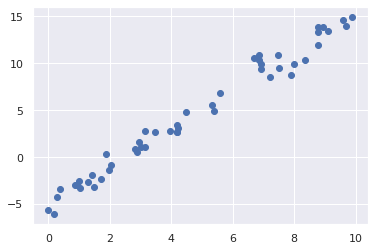

In [2]:
## https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

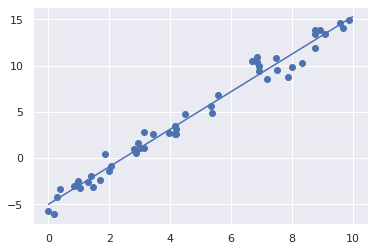

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [5]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606953
Model intercept: -4.998577085553204


In [6]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000051
[ 1.5 -2.   1. ]


In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [8]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

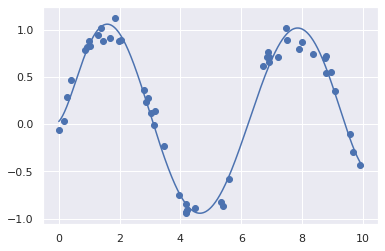

In [9]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

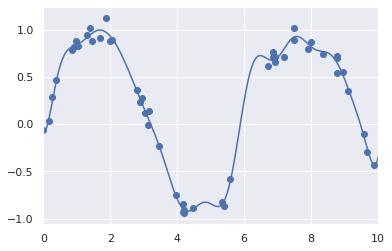

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

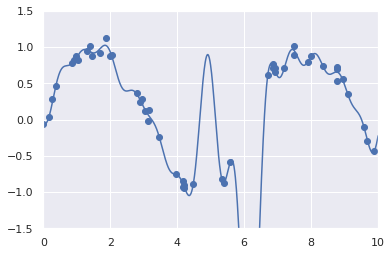

In [14]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

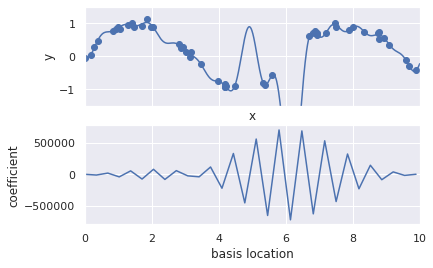

In [17]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

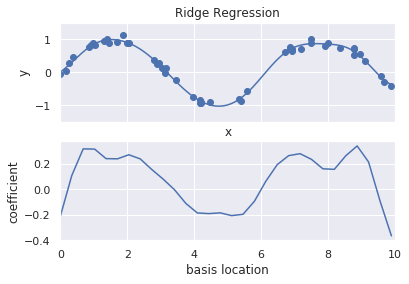

In [18]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021358158704870567, tolerance: 0.002065280097246271
  positive)


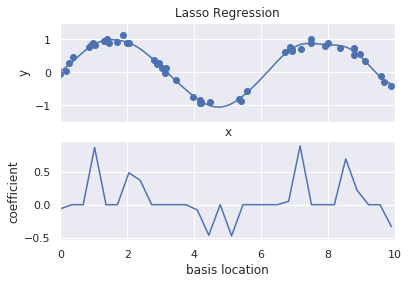

In [19]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

In [21]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2002k    0 2002k    0     0  1130k      0 --:--:--  0:00:01 --:--:-- 1130k


In [23]:
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [30]:
daily = counts.resample('d').sum()
daily.columns
daily['Total'] = daily['Fremont Bridge Total']
daily = daily[['Total']] # remove other columns

In [34]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [35]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)
daily.head

<bound method NDFrame.head of              Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday
Date                                                          
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0
...            ...  ...  ...  ...  ...  ...  ...  ...      ...
2020-01-27  3163.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0
2020-01-28  2729.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0      0.0
2020-01-29  2832.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0
2020-01-30  3025.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0
2020-01-31  2040.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0

[2677 rows x 9 columns]>